In [1]:
from tensorflow.keras.models import load_model
import os
import numpy as np
import json
import random
import nibabel as nib
from scipy.ndimage import zoom
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [29]:
from nibabel.processing import resample_to_output

In [2]:
# Define your data loading and preprocessing function
def load_and_preprocess_data(data_folder, output_folder):

    # Load and preprocess each case
    for case_folder in os.listdir(data_folder):
        case_path = os.path.join(data_folder, case_folder)
        if os.path.isdir(case_path):
            case_output_path = os.path.join(output_folder, case_folder)
            os.makedirs(case_output_path, exist_ok=True)
            
            # Load modalities and masks
            t1n_path = os.path.join(case_path, f'{case_folder}-t1n.nii.gz')
            t1c_path = os.path.join(case_path, f'{case_folder}-t1c.nii.gz')
            t2f_path = os.path.join(case_path, f'{case_folder}-t2f.nii.gz')
            t2w_path = os.path.join(case_path, f'{case_folder}-t2w.nii.gz')
            
            t1n_img = nib.load(t1n_path).get_fdata()
            t1c_img = nib.load(t1c_path).get_fdata()
            t2f_img = nib.load(t2f_path).get_fdata()
            t2w_img = nib.load(t2w_path).get_fdata()

            
            # Resize images to 128x128x128
            target_shape = (128, 128, 128)
            t1n_resized = resize_image(t1n_img, target_shape)
            t1c_resized = resize_image(t1c_img, target_shape)
            t2f_resized = resize_image(t2f_img, target_shape)
            t2w_resized = resize_image(t2w_img, target_shape)
            
            
            # Preprocess (e.g., normalize) on-the-fly
            t1n_preprocessed = preprocess_function(t1n_resized)
            t1c_preprocessed = preprocess_function(t1c_resized)
            t2f_preprocessed = preprocess_function(t2f_resized)
            t2w_preprocessed = preprocess_function(t2w_resized)
            
            
            # Save preprocessed data
            np.save(os.path.join(case_output_path, f'{case_folder}_preprocessed_t1n.npy'), t1n_preprocessed)
            np.save(os.path.join(case_output_path, f'{case_folder}_preprocessed_t1c.npy'), t1c_preprocessed)
            np.save(os.path.join(case_output_path, f'{case_folder}_preprocessed_t2f.npy'), t2f_preprocessed)
            np.save(os.path.join(case_output_path, f'{case_folder}_preprocessed_t2w.npy'), t2w_preprocessed)
  
# Set your data and output paths
data_folder = 'C:/Users/MAILAB/Desktop/ExperimentDataset/BraTSAfrica/Validation'
output_folder = 'D:/Model_Testing_Data'

# Define the resizing function
def resize_image(image, target_shape, is_segmentation=False):
    # Use nearest-neighbor interpolation for segmentation masks
    interpolation = 'nearest' if is_segmentation else 'reflect'
    
    # Calculate the resize factors for each dimension
    resize_factors = [target_dim / current_dim for target_dim, current_dim in zip(target_shape, image.shape)]
    
    # Resize the image using zoom
    resized_image = zoom(image, resize_factors, order=0 if is_segmentation else 3, mode=interpolation)
    
    return resized_image

# Define the preprocess_function (e.g., normalization)
def preprocess_function(image):
    # Normalize to [0, 1]
    image = image.astype(np.float32) / np.max(image)
    return image

# Call the function to load and preprocess data
load_and_preprocess_data(data_folder, output_folder)


In [42]:
# Load the saved model
loaded_model = load_model('Restart_3D_model.h5')

# Load and preprocess a test case with all modalities

test_folder = 'D:\Model_Testing_Data'
case_folder = 'BraTS-SSA-00143-000'

case_path = os.path.join(test_folder, case_folder)
# Replace these paths with the actual paths to your test case modalities

test_case_t1n = os.path.join(case_path, f"{case_folder}_preprocessed_t1n.npy")
test_case_t1c = os.path.join(case_path, f"{case_folder}_preprocessed_t1c.npy")
test_case_t2f = os.path.join(case_path, f"{case_folder}_preprocessed_t2f.npy")
test_case_t2w = os.path.join(case_path, f"{case_folder}_preprocessed_t2w.npy")
    
t1n = np.load(test_case_t1n)
t1c = np.load(test_case_t1c)
t2f = np.load(test_case_t2f)
t2w = np.load(test_case_t2w)

# Preprocess the modalities as needed, e.g., normalize and reshape

# Create the input for the model
test_case_input = np.stack([t1n, t1c, t2f, t2w], axis=-1)

# Make predictions using the loaded model
predictions = loaded_model.predict(np.expand_dims(test_case_input, axis=0))

# Process the predictions as needed
# For example, you can threshold the predictions for binary segmentation
# Or, if it's multi-class segmentation, process the output for class labels


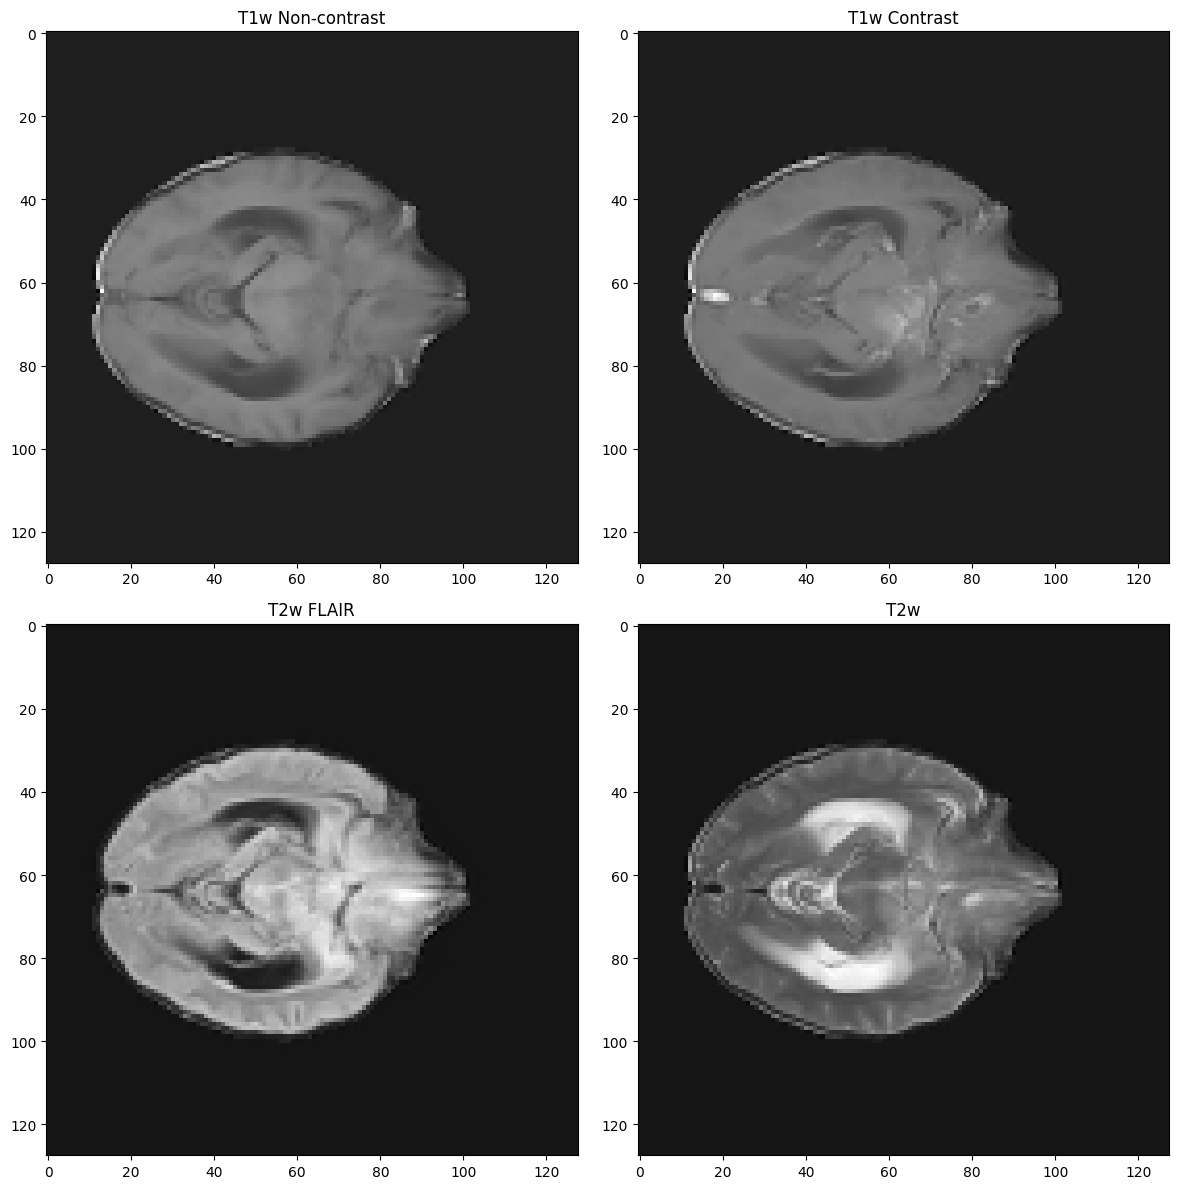

In [43]:
# Assuming test_case_input has already been defined
slice_number = 50  # Change this to the desired slice number

# Get the specified slice from each modality
slice_t1n = test_case_input[:, :, slice_number, 0]  # Modality 0 (t1n)
slice_t1c = test_case_input[:, :, slice_number, 1]  # Modality 1 (t1c)
slice_t2f = test_case_input[:, :, slice_number, 2]  # Modality 2 (t2f)
slice_t2w = test_case_input[:, :, slice_number, 3]  # Modality 3 (t2w)

# Plot the slices using matplotlib
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.imshow(slice_t1n, cmap='gray')
plt.title('T1w Non-contrast')

plt.subplot(2, 2, 2)
plt.imshow(slice_t1c, cmap='gray')
plt.title('T1w Contrast')

plt.subplot(2, 2, 3)
plt.imshow(slice_t2f, cmap='gray')
plt.title('T2w FLAIR')

plt.subplot(2, 2, 4)
plt.imshow(slice_t2w, cmap='gray')
plt.title('T2w')

plt.tight_layout()
plt.show()


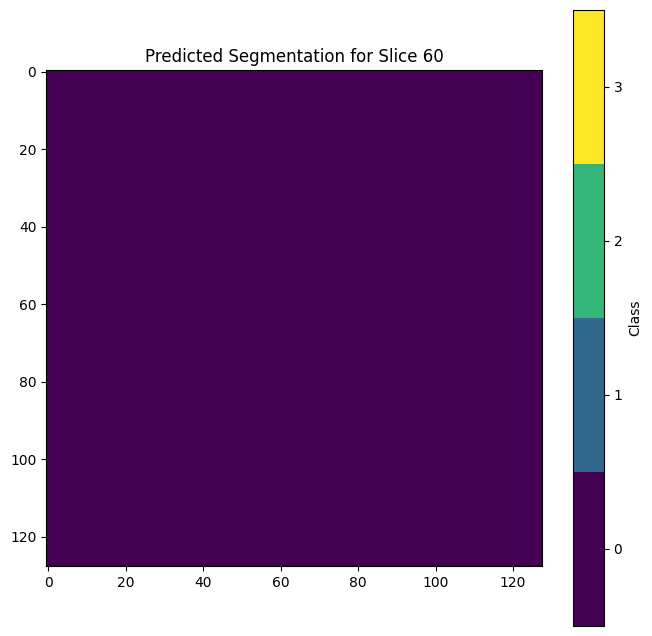

In [44]:
# Make predictions using the loaded model
predictions = loaded_model.predict(np.expand_dims(test_case_input, axis=0))
predicted_class = np.argmax(predictions[0], axis=-1)  # Get the predicted class for each pixel

# Specify the slice number you want to visualize
slice_number = 60  # Change this to the desired slice number

# Get the predicted segmentation mask for the specified slice
predicted_mask_slice = predicted_class[:, :, slice_number]

# Define your class names
class_names = ['Background', 'WT', 'TC','ET']  # Replace with actual class names

# Plot the predicted segmentation mask
plt.figure(figsize=(8, 8))
plt.imshow(predicted_mask_slice, cmap='viridis', vmin=0, vmax=len(class_names)-1)
plt.colorbar(ticks=range(len(class_names)), label='Class', values=range(len(class_names)))
plt.title(f'Predicted Segmentation for Slice {slice_number}')
plt.show()


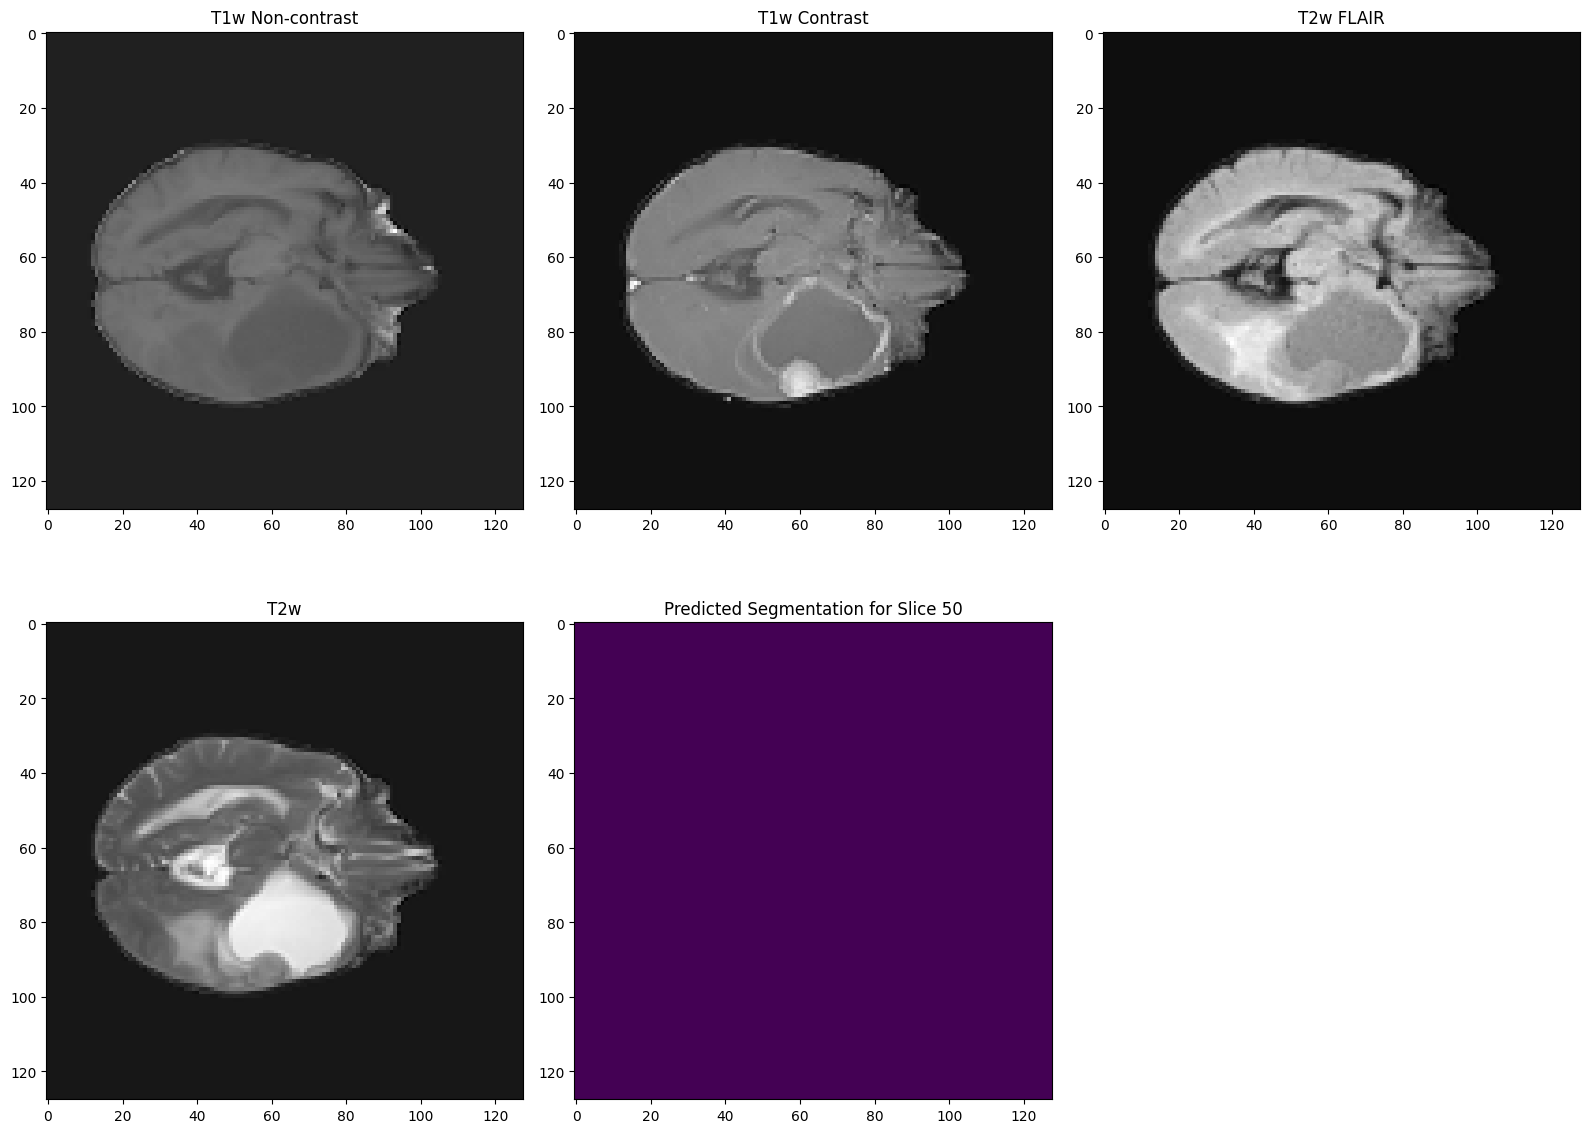

In [22]:
# Assuming test_case_input has already been defined
slice_number = 50  # Change this to the desired slice number

# Get the specified slice from each modality
slice_t1n = test_case_input[:, :, slice_number, 0]  # Modality 0 (t1n)
slice_t1c = test_case_input[:, :, slice_number, 1]  # Modality 1 (t1c)
slice_t2f = test_case_input[:, :, slice_number, 2]  # Modality 2 (t2f)
slice_t2w = test_case_input[:, :, slice_number, 3]  # Modality 3 (t2w)

# Make predictions using the loaded model
predictions = loaded_model.predict(np.expand_dims(test_case_input, axis=0))
predicted_class = np.argmax(predictions[0], axis=-1)  # Get the predicted class for each pixel

# Get the predicted segmentation mask for the specified slice
predicted_mask_slice = predicted_class[:, :, slice_number]

# Define your class names
class_names = ['Background', 'WT', 'TC', 'ET']  # Replace with actual class names

# Plot the slices using matplotlib
plt.figure(figsize=(16, 12))

plt.subplot(2, 3, 1)
plt.imshow(slice_t1n, cmap='gray')
plt.title('T1w Non-contrast')

plt.subplot(2, 3, 2)
plt.imshow(slice_t1c, cmap='gray')
plt.title('T1w Contrast')

plt.subplot(2, 3, 3)
plt.imshow(slice_t2f, cmap='gray')
plt.title('T2w FLAIR')

plt.subplot(2, 3, 4)
plt.imshow(slice_t2w, cmap='gray')
plt.title('T2w')

plt.subplot(2, 3, 5)
plt.imshow(predicted_mask_slice, cmap='viridis', vmin=0, vmax=len(class_names)-1)
#plt.colorbar(ticks=range(len(class_names)), label='Class', values=range(len(class_names)))
plt.title(f'Predicted Segmentation for Slice {slice_number}')

plt.tight_layout()
plt.show()


In [23]:
# Make predictions using the loaded model
predictions = loaded_model.predict(np.expand_dims(test_case_input, axis=0))
predicted_class = np.argmax(predictions[0], axis=-1)  # Get the predicted class for each pixel

# Convert the predicted_class to uint8
predicted_class_uint8 = predicted_class.astype(np.uint8)

# Create a NIfTI image from the predicted segmentation
nifti_img = nib.Nifti1Image(predicted_class_uint8, affine=np.eye(4), header=None)

# Specify the path to save the NIfTI segmentation
output_nifti_path = 'D:\Segmented\predicted_segmentation.nii.gz'  # Change the filename as needed

# Save the NIfTI segmentation image to file
nib.save(nifti_img, output_nifti_path)

print(f'Segmentation saved to {output_nifti_path}')


Segmentation saved to D:\Segmented\predicted_segmentation.nii.gz


In [38]:
# Specify the folder containing subfolders with test cases
input_folder = 'D:\Model_Testing_Data'

# Define the target dimension and origin
target_shape = (240, 240, 155)
target_origin = [0, -239, 0]

# Iterate through subfolders in the input folder
for case_folder in os.listdir(input_folder):
    case_path = os.path.join(input_folder, case_folder)
    
    # Load modalities for the case
    t1n = np.load(os.path.join(case_path, f"{case_folder}_preprocessed_t1n.npy"))
    t1c = np.load(os.path.join(case_path, f"{case_folder}_preprocessed_t1c.npy"))
    t2f = np.load(os.path.join(case_path, f"{case_folder}_preprocessed_t2f.npy"))
    t2w = np.load(os.path.join(case_path, f"{case_folder}_preprocessed_t2w.npy"))
    
    # Create the input for the model
    test_case_input = np.stack([t1n, t1c, t2f, t2w], axis=-1)
    
    # Make predictions using the loaded model
    predictions = loaded_model.predict(np.expand_dims(test_case_input, axis=0))
    predicted_class = np.argmax(predictions[0], axis=-1)  # Get the predicted class for each pixel
    
    # Convert the predicted_class to uint8
    predicted_class_uint8 = predicted_class.astype(np.uint8)
    
    # Create a NIfTI image from the predicted segmentation
    nifti_img = nib.Nifti1Image(predicted_class_uint8, affine=np.eye(4), header=None)
    
    # Conform the NIfTI image to the target shape
    nifti_img_conformed = nib.as_closest_canonical(nifti_img)
    nifti_img_resampled = nib.processing.conform(nifti_img_conformed, out_shape=target_shape, voxel_size=(1, 1, 1))
    
    # Specify the path to save the NIfTI segmentation
    output_nifti_path = os.path.join('D:\Segmented', f"{case_folder}.nii.gz")
    
    # Save the NIfTI segmentation image to file
    nib.save(nifti_img_resampled, output_nifti_path)
    
    print(f'Segmentation saved to {output_nifti_path}')


Segmentation saved to D:\Segmented\BraTS-SSA-00126-000.nii.gz
Segmentation saved to D:\Segmented\BraTS-SSA-00129-000.nii.gz
Segmentation saved to D:\Segmented\BraTS-SSA-00132-000.nii.gz
Segmentation saved to D:\Segmented\BraTS-SSA-00139-000.nii.gz
Segmentation saved to D:\Segmented\BraTS-SSA-00143-000.nii.gz
Segmentation saved to D:\Segmented\BraTS-SSA-00148-000.nii.gz
Segmentation saved to D:\Segmented\BraTS-SSA-00158-000.nii.gz
Segmentation saved to D:\Segmented\BraTS-SSA-00169-000.nii.gz
Segmentation saved to D:\Segmented\BraTS-SSA-00180-000.nii.gz
Segmentation saved to D:\Segmented\BraTS-SSA-00188-000.nii.gz
Segmentation saved to D:\Segmented\BraTS-SSA-00192-000.nii.gz
Segmentation saved to D:\Segmented\BraTS-SSA-00198-000.nii.gz
Segmentation saved to D:\Segmented\BraTS-SSA-00210-000.nii.gz
Segmentation saved to D:\Segmented\BraTS-SSA-00218-000.nii.gz
Segmentation saved to D:\Segmented\BraTS-SSA-00227-000.nii.gz
